#Data Helper

In [0]:
from google.colab import drive
drive.mount('/content/drive')
folder = "data/"  # set your path of data

In [0]:
import pandas as pd
import numpy as np

def loaddata(labelfilename,gtfilename):
  gtdf = pd.read_csv(gtfilename,sep='\t',encoding='utf-8')

  sentences = gtdf['sentence'].values.tolist()
  truelabels = {}
  for idx,row in gtdf.iterrows():
    truelabels[row['sentence']] = row['gtlabel'] 

  labeldf = pd.read_csv(labelfilename,sep='\t',encoding='utf-8')

  workers = []
  swlabels = []
  
  for idx,row in labeldf.iterrows():
    worker = row['worker']
    if worker not in workers:
      workers.append(worker)
    workerid = workers.index(worker)
    sentenceid = sentences.index(row['sentence'])
    label = row['label'].strip()
    swlabels.append((sentenceid,workerid,label))
  
  return (workers,sentences,swlabels,truelabels)

def labelformatconversion(workers,sentences,swlabels):
  wlabelidlists = {}
  wsentenceidlists = {}
  for worker in workers:
    wlabelidlists[worker] = []
    wsentenceidlists[worker] = []
    
  slabelidlists = {}
  sworkeridlists = {}
  for sentence in sentences:
    slabelidlists[sentence] = []
    sworkeridlists[sentence] = []
    
  labellist = []
  labelidx = 0
  for (sentenceid,workerid,label) in swlabels:
    labellist.append(label)
    sentence = sentences[sentenceid]
    slabelidlists[sentence].append(labelidx)
    sworkeridlists[sentence].append(workerid)
    worker = workers[workerid]
    wlabelidlists[worker].append(labelidx)
    wsentenceidlists[worker].append(sentenceid)
    labelidx += 1
  
  return (labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists)

def truelabelformatonversion(sentences,truelabels):
  truelabellist = []
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabellist.append(truelabels[sentence])
    
  return truelabellist

# Universal Sentence Encoder

In [0]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import re

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

# Evaluation Method

In [0]:
DEFAULT_SIM_TYPE = 'COSINE'
def similarity(embed1, embed2, simtype = DEFAULT_SIM_TYPE):
  if (simtype == 'COSINE'):
    l1 = np.sqrt(np.sum(embed1**2))
    l2 = np.sqrt(np.sum(embed2**2))
    sim = np.inner(embed1,embed2) / (l1*l2)
  
  return sim

## Embedding

In [0]:
def evaluationbyEmbedding(sentences, elabels, label_embeddings, truelabels, truelabel_embeddings):
  totalsim = 0
  for sentence in elabels:
    elabel_embedding = label_embeddings[elabels[sentence]]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    totalsim += similarity(elabel_embedding,truelabel_embedding)
    
  #print(len(elabels),totalsim/len(elabels))
  return totalsim/len(elabels)
    

## GLEU

In [8]:
#https://github.com/gcunhase/NLPMetrics
#https://colab.research.google.com/github/gcunhase/NLPMetrics/blob/master/notebooks/gleu.ipynb

import nltk
import nltk.translate.gleu_score as gleu

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')

def evaluationbyGLEU(sentences, labels, elabelidxs, truelabels):
  n = len(sentences)
  sim = 0
  for i in range(n):
    sentence = sentences[i]
    labelidx = elabelidxs[sentence]
    label = labels[labelidx]
    truelabel = truelabels[sentence]
    sim += gleu.sentence_gleu([truelabel.split()], label.split())
  #print(n,sim/n)
  return sim/n

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Figures in Exploration Study

## Embedding

### Worker Reliability

In [0]:
def WorkerReliabilityEmbedding(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, label_embeddings, truelabel_embeddings):  
  w_num = len(workers)
  reliability = np.zeros(w_num)
  s_num = len(sentences)

  # compute reliability
  for j in range(w_num): 
    worker = workers[j]
    wtruelabel_embeddings = truelabel_embeddings[wsentenceidlists[worker]]
    wlabelidlist = wlabelidlists[worker]
    wlabel_embeddings = label_embeddings[wlabelidlist]
    
    nw = len(wlabel_embeddings)
    totalsim = 0
    for i in range(nw):
      elabel_embedding = wlabel_embeddings[i]
      truelabel_embedding = wtruelabel_embeddings[i]
      totalsim += similarity(elabel_embedding,truelabel_embedding)
    reliability[j] = totalsim / nw
    
  return reliability

def DatasetWorkerReliabilityEmbedding(labelfilename,gtfilename):
  (workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
  (labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
  (truelabellist) = truelabelformatonversion(sentences,truelabels)

  embed = hub.Module(module_url)
  tf.logging.set_verbosity(tf.logging.ERROR)
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    label_embeddings = session.run(embed(labellist))
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    truelabel_embeddings = session.run(embed(truelabellist))

  workerreliability = WorkerReliabilityEmbedding(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, label_embeddings, truelabel_embeddings)
  
  return workerreliability


In [10]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'
j1workerreliability = DatasetWorkerReliabilityEmbedding(labelfilename,gtfilename)

# T1
labelfilename = folder + 'CrowdWSA2019_T1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'
t1workerreliability = DatasetWorkerReliabilityEmbedding(labelfilename,gtfilename)

# T2
labelfilename = folder + 'CrowdWSA2019_T2_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'
t2workerreliability = DatasetWorkerReliabilityEmbedding(labelfilename,gtfilename)

print([np.mean(j1workerreliability),np.mean(t1workerreliability),np.mean(t2workerreliability)])

[0.7251129552895824, 0.7873152441495942, 0.7679060591121978]


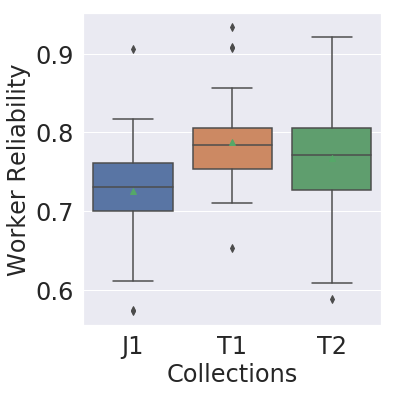

In [11]:
import seaborn as sns

rc={'figure.figsize':(6,6), 'font.size': 24, 'axes.labelsize': 24, 'legend.fontsize': 24, 
    'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24}
sns.set(rc=rc)

plt = sns.boxplot(data=[j1workerreliability,t1workerreliability,t2workerreliability],showmeans=True)
plt.set_xlabel("Collections")
plt.set_ylabel("Worker Reliability")
plt.set_xticklabels(['J1','T1','T2'])
plt.figure.tight_layout()

### Question Reliability

In [0]:
def QuestionReliabilityEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings):
  reliability = np.zeros(len(sentences))
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    ns = len(slabel_embeddings)
    sim = 0
    for k in range(ns):
      label_embedding = slabel_embeddings[k]
      sim += similarity(label_embedding,truelabel_embedding)
    reliability[i] = sim / ns
  
  return reliability

def DatasetQuestionReliabilityEmbedding(labelfilename,gtfilename):
  (workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
  (labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
  (truelabellist) = truelabelformatonversion(sentences,truelabels)

  embed = hub.Module(module_url)
  tf.logging.set_verbosity(tf.logging.ERROR)
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    label_embeddings = session.run(embed(labellist))
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    truelabel_embeddings = session.run(embed(truelabellist))

  questionreliability = QuestionReliabilityEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings)
  
  return questionreliability

In [13]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'
j1questionreliability = DatasetQuestionReliabilityEmbedding(labelfilename,gtfilename)

# T1
labelfilename = folder + 'CrowdWSA2019_T1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'
t1questionreliability = DatasetQuestionReliabilityEmbedding(labelfilename,gtfilename)

# T2
labelfilename = folder + 'CrowdWSA2019_T2_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'
t2questionreliability = DatasetQuestionReliabilityEmbedding(labelfilename,gtfilename)

print([np.mean(j1questionreliability),np.mean(t1questionreliability),np.mean(t2questionreliability)])

[0.7354236014988688, 0.785080416202545, 0.7696036003232004]


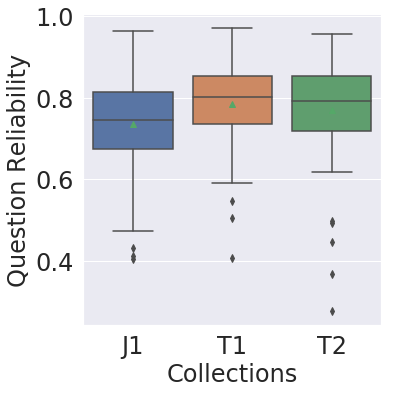

In [14]:
import seaborn as sns

rc={'figure.figsize':(6,6), 'font.size': 24, 'axes.labelsize': 24, 'legend.fontsize': 24, 
    'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24}
sns.set(rc=rc)

plt = sns.boxplot(data=[j1questionreliability,t1questionreliability,t2questionreliability],showmeans=True)
plt.set_xlabel("Collections")
plt.set_ylabel("Question Reliability")
plt.set_xticklabels(['J1','T1','T2'])
plt.figure.tight_layout()

##GLEU

### Worker GLEU

In [0]:
def WorkerReliabilityGLEU(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, labels, truelabels):  
  w_num = len(workers)
  reliability = np.zeros(w_num)
  s_num = len(sentences)

  for j in range(w_num): 
    worker = workers[j]
    wtruelabels = truelabels[wsentenceidlists[worker]]
    wlabelidlist = wlabelidlists[worker]
    wlabels = labels[wlabelidlist]
    
    nw = len(wlabels)
    totalsim = 0
    for i in range(nw):
      label = wlabels[i]
      truelabel = wtruelabels[i]
      totalsim += gleu.sentence_gleu([truelabel.split()], label.split())
    reliability[j] = totalsim / nw
    
  return reliability

In [16]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

(workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
(labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
(truelabellist) = truelabelformatonversion(sentences,truelabels)

reliability = WorkerReliabilityGLEU(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, np.asarray(labellist), np.asarray(truelabellist))
j1workergleu = reliability

# T1
labelfilename = folder + 'CrowdWSA2019_T1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

(workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
(labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
(truelabellist) = truelabelformatonversion(sentences,truelabels)

reliability = WorkerReliabilityGLEU(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, np.asarray(labellist), np.asarray(truelabellist))
t1workergleu = reliability

# T2
labelfilename = folder + 'CrowdWSA2019_T2_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

(workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
(labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
(truelabellist) = truelabelformatonversion(sentences,truelabels)

reliability = WorkerReliabilityGLEU(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, np.asarray(labellist), np.asarray(truelabellist))
t2workergleu = reliability

print([np.mean(j1workergleu),np.mean(t1workergleu),np.mean(t2workergleu)])

[0.1868012686336684, 0.17641370367716142, 0.17155530496426646]


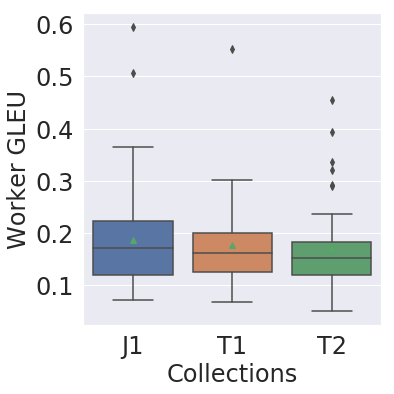

In [17]:
import seaborn as sns

rc={'figure.figsize':(6,6), 'font.size': 24, 'axes.labelsize': 24, 'legend.fontsize': 24, 
    'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24}
sns.set(rc=rc)

plt = sns.boxplot(data=[j1workergleu,t1workergleu,t2workergleu],showmeans=True)
plt.set_xlabel("Collections")
plt.set_ylabel("Worker GLEU")
plt.set_xticklabels(['J1','T1','T2'])
plt.figure.tight_layout()

###Question GLEU

In [0]:
def QuestionReliabilityGLEU(sentences, slabelidlists, labels, truelabels):
  reliability = np.zeros(len(sentences))
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    ns = len(slabels)
    sim = 0
    for k in range(ns):
      label = slabels[k]
      sim += gleu.sentence_gleu([truelabel.split()], label.split())
    reliability[i] = sim / ns
  
  return reliability

In [19]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

(workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
(labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
(truelabellist) = truelabelformatonversion(sentences,truelabels)

quality = QuestionReliabilityGLEU(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))
j1questiongleu = quality

# T1
labelfilename = folder + 'CrowdWSA2019_T1_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

(workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
(labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
(truelabellist) = truelabelformatonversion(sentences,truelabels)

quality = QuestionReliabilityGLEU(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))
t1questiongleu = quality

# T2
labelfilename = folder + 'CrowdWSA2019_T2_label.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

(workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
(labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
(truelabellist) = truelabelformatonversion(sentences,truelabels)

quality = QuestionReliabilityGLEU(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))
t2questiongleu = quality

print([np.mean(j1questiongleu),np.mean(t1questiongleu),np.mean(t2questiongleu)])

[0.1929833036876219, 0.17403443483987385, 0.16158265928021784]


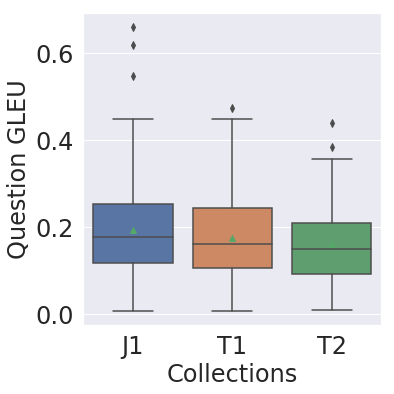

In [20]:
import seaborn as sns

rc={'figure.figsize':(6,6), 'font.size': 24, 'axes.labelsize': 24, 'legend.fontsize': 24, 
    'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24}
sns.set(rc=rc)

plt = sns.boxplot(data=[j1questiongleu,t1questiongleu,t2questiongleu],showmeans=True)
plt.set_xlabel("Collections")
plt.set_ylabel("Question GLEU")
plt.set_xticklabels(['J1','T1','T2'])
plt.figure.tight_layout()